Notebook used to visualize AINI variables

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.lines import Line2D
from scipy.stats import shapiro


In [ ]:
# Get notebook's current file location 
project_root = Path().resolve().parents[0] 

# get reports path for figures (see below)
fig_path = project_root / "reports" / "figures" / "binary"

# go to data folder
data = project_root / "data" / "processed" / "variables"

# read csv
df_full = pd.read_csv(data / "AINI_variables.csv")

# verify load
print(f"there are {len(df_full)} articles")

there are 781 articles


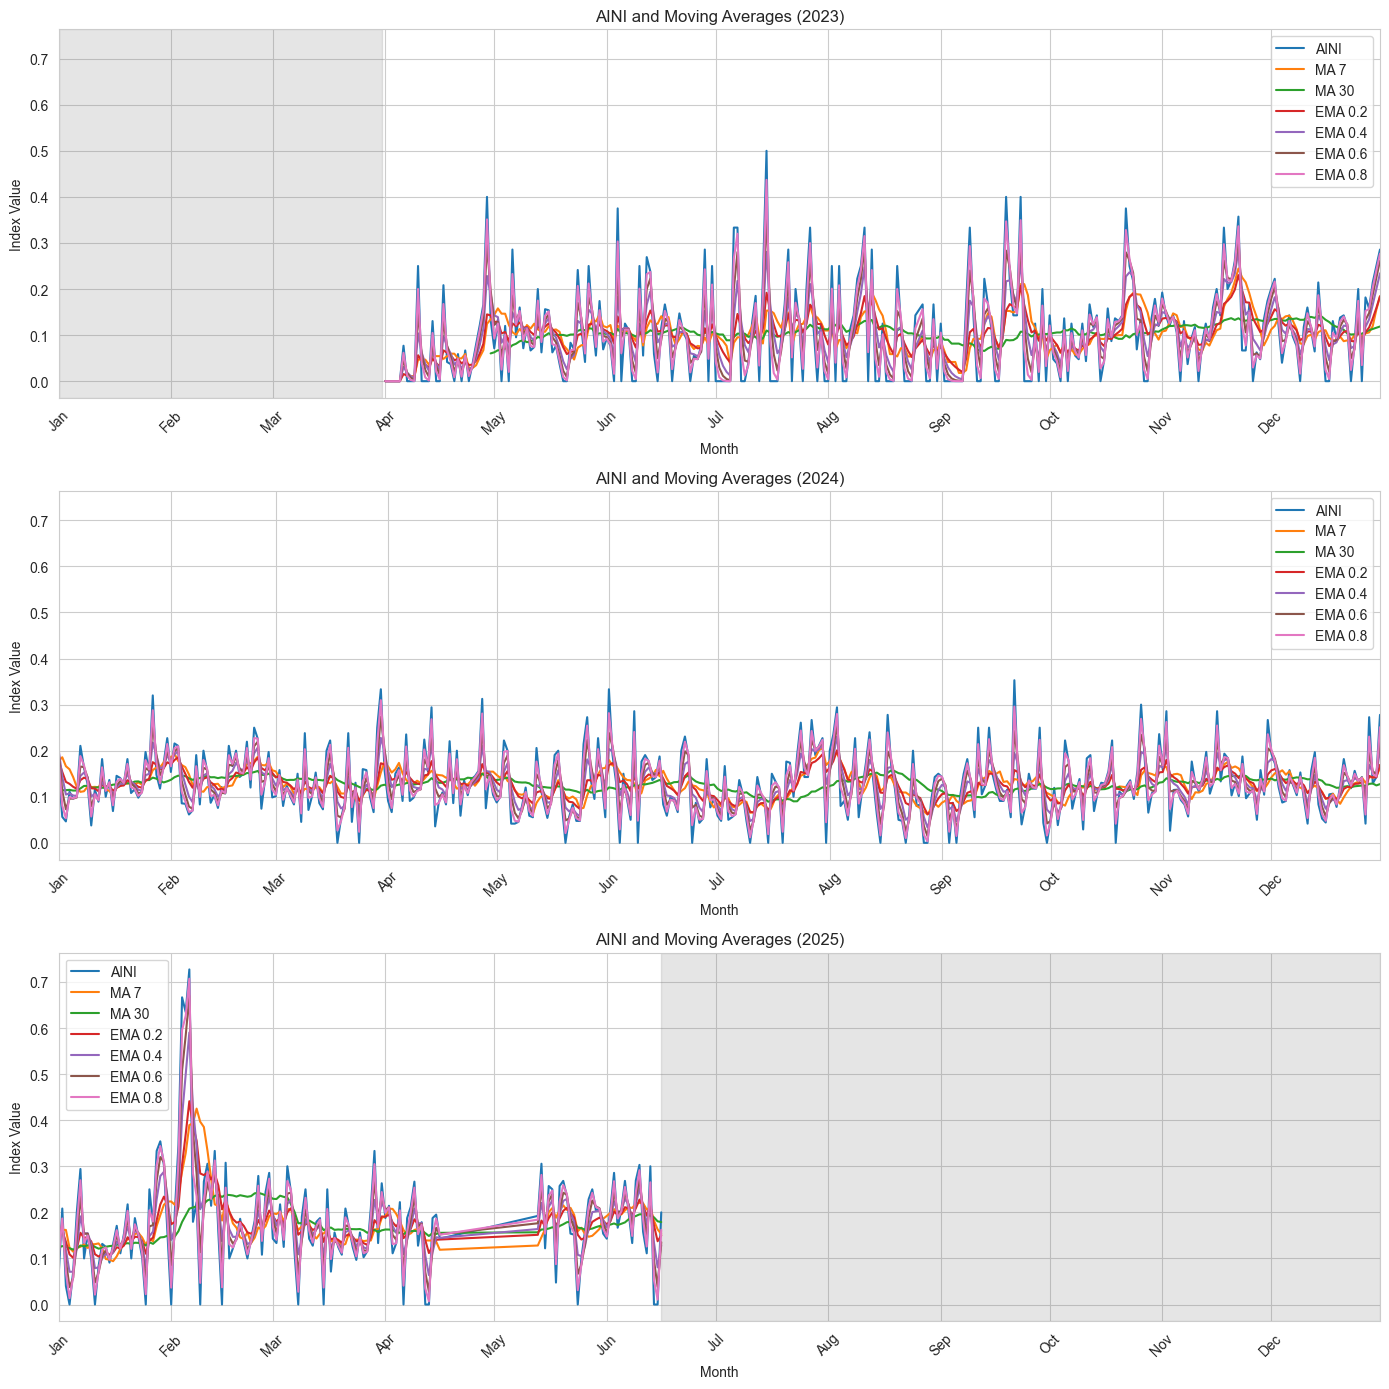

In [ ]:
# Reset index to make 'date' a column again
df_full = df_full.reset_index()

# Convert date column to datetime
df_full['date'] = pd.to_datetime(df_full['date'])

# Create separate DataFrames for 2023, 2024, and 2025
df_2023 = df_full[df_full['date'].dt.year == 2023]
df_2024 = df_full[df_full['date'].dt.year == 2024]
df_2025 = df_full[df_full['date'].dt.year == 2025]

# Set seaborn style
sns.set_style("whitegrid")

# Create 3 vertically stacked subplots with shared y-axis
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 14), sharey=True)

# Define a plotting function to reduce repetition
def plot_yearly_data(ax, df, year):
    sns.lineplot(ax=ax, data=df, x="date", y="normalized_AINI", label="AINI")
    sns.lineplot(ax=ax, data=df, x="date", y="MA_7", label="MA 7")
    sns.lineplot(ax=ax, data=df, x="date", y="MA_30", label="MA 30")
    sns.lineplot(ax=ax, data=df, x="date", y="EMA_02", label="EMA 0.2")
    sns.lineplot(ax=ax, data=df, x="date", y="EMA_04", label="EMA 0.4")
    sns.lineplot(ax=ax, data=df, x="date", y="EMA_06", label="EMA 0.6")
    sns.lineplot(ax=ax, data=df, x="date", y="EMA_08", label="EMA 0.8")
    ax.set_xlim([datetime(year, 1, 1), datetime(year, 12, 31)])
    ax.set_title(f"AINI and Moving Averages ({year})")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Index Value")
    ax.set_xlabel("Month")
    ax.legend()

# Plot each year
plot_yearly_data(axes[0], df_2023, 2023)
plot_yearly_data(axes[1], df_2024, 2024)
plot_yearly_data(axes[2], df_2025, 2025)

# Shade pre-April 2023 & post june 15 2025
axes[0].axvspan(datetime(2023, 1, 1), datetime(2023, 3, 31), color='gray', alpha=0.2, label="insufficient data")
last_data = df_2025["date"].max()
axes[2].axvspan(last_data, datetime(2025, 12, 31), color='gray', alpha=0.2, label="no data")

# Layout and save
plt.tight_layout()
plt.savefig(fig_path / "AINI_MA_23_24_25.png")
plt.show()


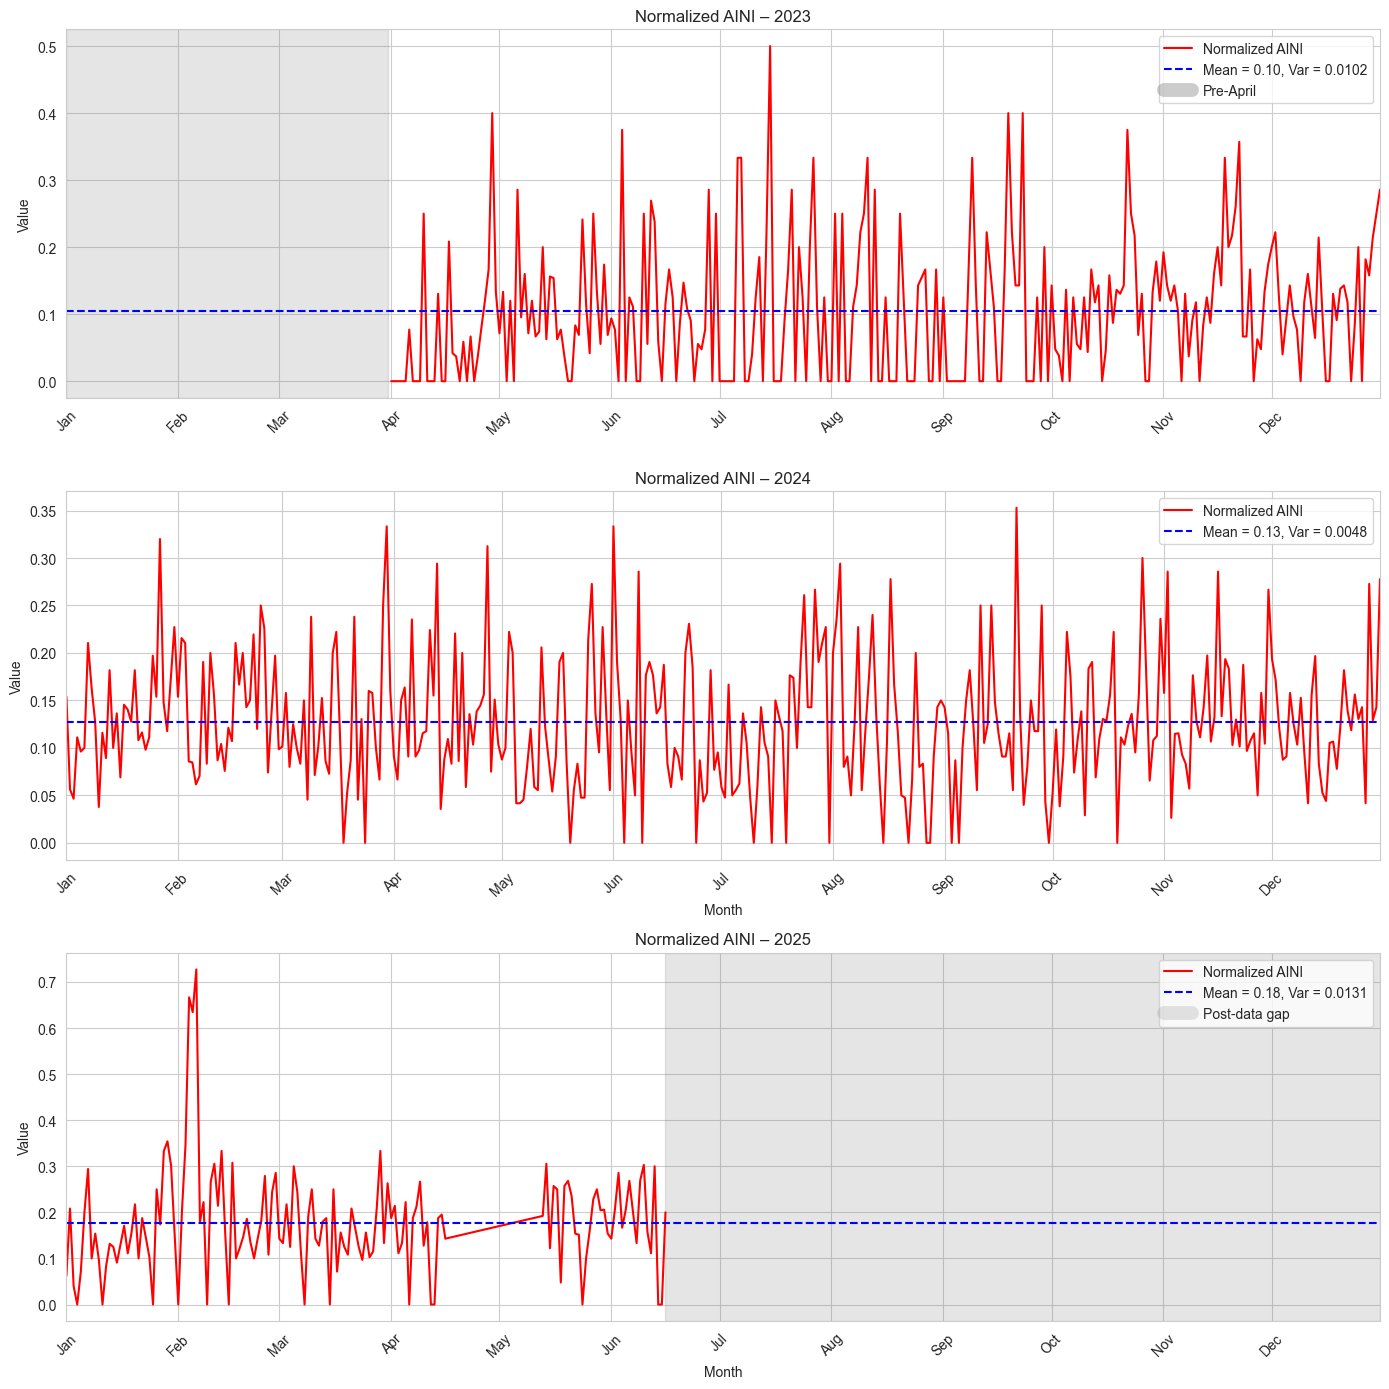

In [6]:
# === Calculate mean and variance ===
mean_23 = df_2023["normalized_AINI"].mean()
var_23 = df_2023["normalized_AINI"].var()

mean_24 = df_2024["normalized_AINI"].mean()
var_24 = df_2024["normalized_AINI"].var()

df_2025 = df_full[df_full['date'].dt.year == 2025]
mean_25 = df_2025["normalized_AINI"].mean()
var_25 = df_2025["normalized_AINI"].var()

# === Plotting ===
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 14), sharey=False)

# === Plotting Function with Optional Post-Data Shading ===
def plot_year(ax, df, year, mean, var, shade=False, post_data_shade=False):
    sns.lineplot(ax=ax, data=df, x="date", y="normalized_AINI", label="Normalized AINI", color="red")
    ax.hlines(mean, xmin=datetime(year, 1, 1), xmax=datetime(year, 12, 31), color='blue', linestyle='--', label="_nolegend_")
    
    legend_elements = [
        Line2D([0], [0], color='red', label='Normalized AINI'),
        Line2D([0], [0], color='blue', linestyle='--', label=f'Mean = {mean:.2f}, Var = {var:.4f}')
    ]
    
    # Shade Jan–Mar
    if shade:
        ax.axvspan(datetime(year, 1, 1), datetime(year, 3, 31), color='gray', alpha=0.2, label="_nolegend_")
        legend_elements.append(Line2D([0], [0], color='gray', alpha=0.4, lw=10, label='Pre-April'))

    # Shade post-last-data gap (only if enabled and data is present)
    if post_data_shade and not df.empty:
        last_date = df["date"].max()
        end_of_year = datetime(year, 12, 31)
        if pd.notnull(last_date) and last_date < end_of_year:
            ax.axvspan(last_date, end_of_year, color='gray', alpha=0.2, label="_nolegend_")
            legend_elements.append(Line2D([0], [0], color='gray', alpha=0.2, lw=10, label='Post-data gap'))

    ax.legend(handles=legend_elements)
    ax.set_title(f"Normalized AINI – {year}")
    ax.set_xlim([datetime(year, 1, 1), datetime(year, 12, 31)])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Value")
    ax.set_xlabel("Month" if year != 2023 else "")

# === Plot Each Year
plot_year(axes[0], df_2023, 2023, mean_23, var_23, shade=True)
plot_year(axes[1], df_2024, 2024, mean_24, var_24)
plot_year(axes[2], df_2025, 2025, mean_25, var_25, post_data_shade=True)

# Final layout and export
plt.tight_layout()
plt.savefig(fig_path / "AINI_norm_23_24_25.png")
plt.show()


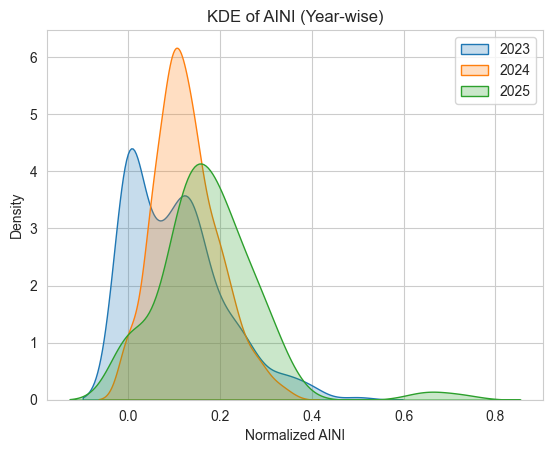

In [8]:
# inspect disrtibution via KDE
sns.kdeplot(df_2023["normalized_AINI"], label="2023", fill=True)
sns.kdeplot(df_2024["normalized_AINI"], label="2024", fill=True)
sns.kdeplot(df_2025["normalized_AINI"], label="2025", fill=True)
plt.title("KDE of AINI (Year-wise)")
plt.xlabel("Normalized AINI")
plt.legend()
plt.show()


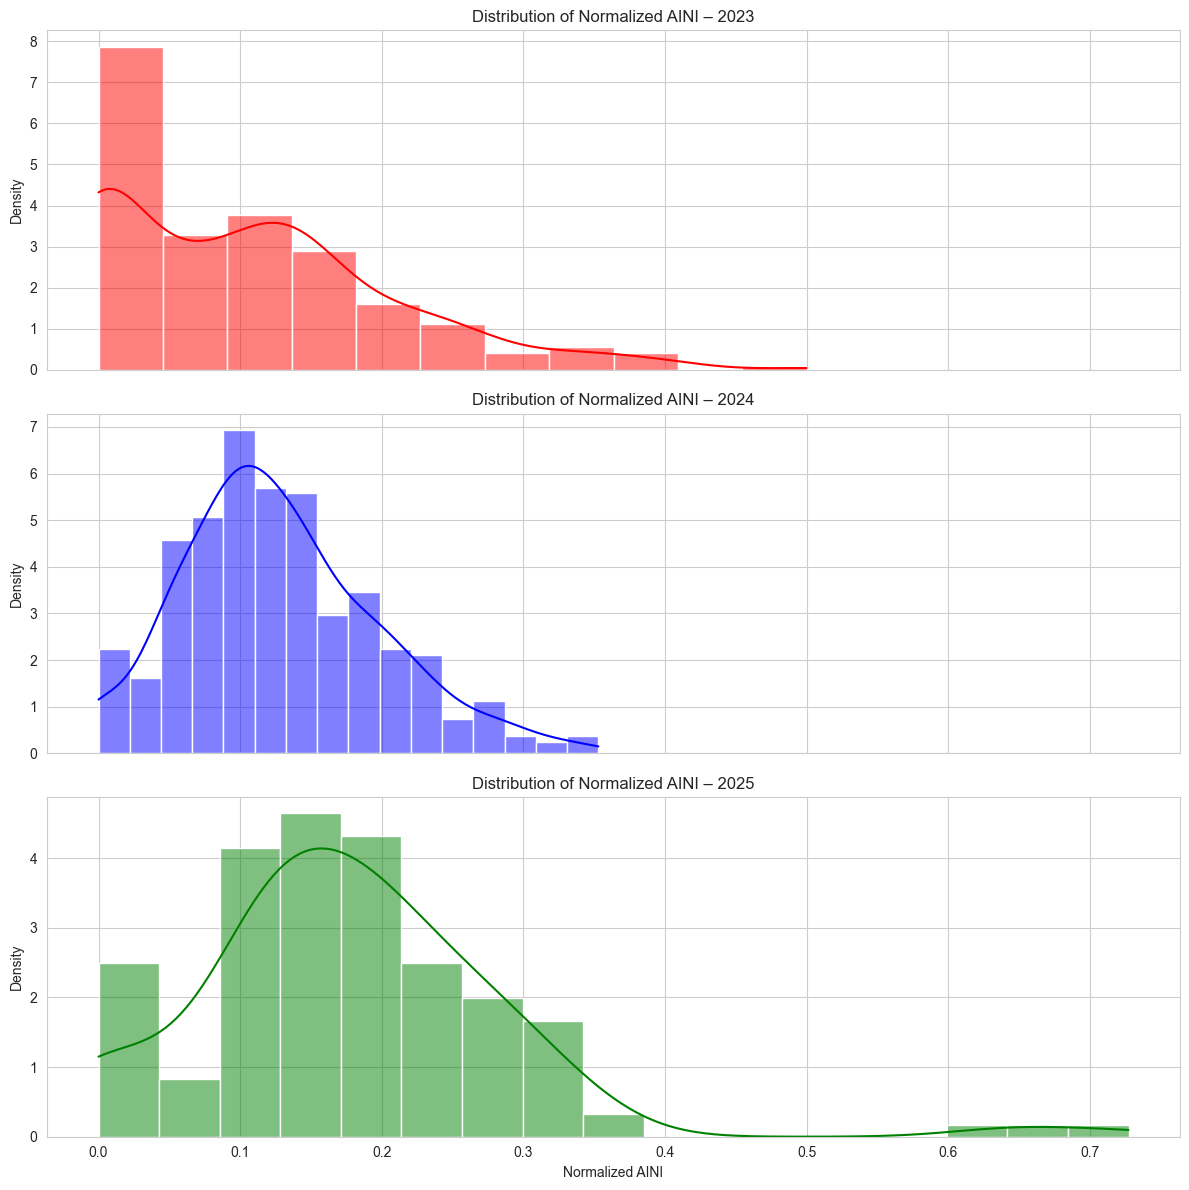

In [13]:
# Set seaborn style
sns.set_style("whitegrid")

# Create 3 vertically stacked subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

# Plot for 2023
sns.histplot(df_2023["normalized_AINI"], kde=True, color='red', stat="density", ax=axes[0])
axes[0].set_title("Distribution of Normalized AINI – 2023")
axes[0].set_ylabel("Density")

# Plot for 2024
sns.histplot(df_2024["normalized_AINI"], kde=True, color='blue', stat="density", ax=axes[1])
axes[1].set_title("Distribution of Normalized AINI – 2024")
axes[1].set_ylabel("Density")

# Plot for 2025
sns.histplot(df_2025["normalized_AINI"], kde=True, color='green', stat="density", ax=axes[2])
axes[2].set_title("Distribution of Normalized AINI – 2025")
axes[2].set_xlabel("Normalized AINI")
axes[2].set_ylabel("Density")

# Final layout
plt.tight_layout()
plt.savefig(fig_path / "AINI_norm_histplot_by_year.png")
plt.show()

